
# Tâche 1 — Reconnaissance Faciale (Matching)
## 1. Introduction & Objectifs
- Objectif : déterminer si deux images représentent la même personne (matching).
- Données : `data/train` (2000 personnes × 2 photos `XXXX_0`/`XXXX_1`), `data/test` (2000 images).
- Livrables : 
  - `results/face_matching/face_matching_predictions.csv`
  - `models/face_matching/face_matching_best.pth`
  - Notebook complet (ce fichier)

## 2. Chargement des librairies & Configuration
- Import des librairies (torch, torchvision, opencv…)
- Lecture du fichier de config : `src/utils/config_t1.yaml`

In [20]:
# === Rendre src importable depuis notebooks/ ===
import os, sys
sys.path.insert(0, os.path.abspath(".."))

# === Config YAML ===
import yaml
with open("../src/utils/config_t1.yaml") as f:
    config = yaml.safe_load(f)

# === Imports modèle ===
from src.models import FaceMatchingNet

print("Configuration Tâche 1 chargée ✅")
print("FaceMatchingNet importé ✅")

Configuration Tâche 1 chargée ✅
FaceMatchingNet importé ✅


## 3. Exploration du dataset
- Vérifier volumes, formats, exemples d’images
- Journaliser : nb images, nb personnes, distribution

In [2]:
import os
from torch.utils.data import Dataset, DataLoader
from PIL import Image
import torchvision.transforms as transforms

class FaceDataset(Dataset):
    def __init__(self, root_dir, transform=None):
        self.root_dir = root_dir
        self.transform = transform
        self.samples = []

        for fname in os.listdir(root_dir):
            if fname.endswith(".jpg") or fname.endswith(".png"):
                self.samples.append(fname)

    def __len__(self):
        return len(self.samples)

    def __getitem__(self, idx):
        fname = self.samples[idx]
        img_path = os.path.join(self.root_dir, fname)
        image = Image.open(img_path).convert("RGB")

        if self.transform:
            image = self.transform(image)

        return image, fname


# Configuration DataLoader
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor()
])

train_loader_t1 = DataLoader(
    FaceDataset("../data/tache1/train", transform=transform),
    batch_size=4,
    shuffle=True
)

test_loader_t1 = DataLoader(
    FaceDataset("../data/tache1/test", transform=transform),
    batch_size=4,
    shuffle=False
)

## 4. Construction des paires (positives/négatives)
- Détection/alignement visage
- Normalisation
- Stratégie d’équilibrage des paires
- Règles anti-fuite entre train/val

In [22]:
import os
from torch.utils.data import Dataset, DataLoader
from PIL import Image
import torchvision.transforms as transforms
import torch

# === Dataset de paires ===
class FacePairsDataset(Dataset):
    def __init__(self, pairs_file, root_dir, transform=None):
        self.root_dir = root_dir
        self.transform = transform
        self.pairs = []
        with open(pairs_file, "r") as f:
            for line in f:
                line = line.strip()
                if not line:
                    continue
                img1, img2, label = line.split(",")
                self.pairs.append((img1, img2, int(label)))

    def __len__(self):
        return len(self.pairs)

    def __getitem__(self, idx):
        img1_name, img2_name, label = self.pairs[idx]
        img1 = Image.open(os.path.join(self.root_dir, img1_name)).convert("RGB")
        img2 = Image.open(os.path.join(self.root_dir, img2_name)).convert("RGB")
        if self.transform:
            img1 = self.transform(img1)
            img2 = self.transform(img2)
        return (img1, img2), torch.tensor(label, dtype=torch.float32)


# === Chemins fixes ===
TRAIN_IMAGES = "../data/tache1/train"
TEST_IMAGES  = "../data/tache1/test"
TRAIN_PAIRS  = "../data/tache1/train_pairs.csv"
TEST_PAIRS   = "../data/tache1/test_pairs.csv"

# === Transformations ===
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor()
])

# === DataLoaders ===
train_loader_t1 = DataLoader(
    FacePairsDataset(TRAIN_PAIRS, TRAIN_IMAGES, transform=transform),
    batch_size=config["training"]["batch_size"],
    shuffle=True,
    num_workers=0
)

val_loader_t1 = DataLoader(
    FacePairsDataset(TEST_PAIRS, TEST_IMAGES, transform=transform),
    batch_size=config["training"]["batch_size"],
    shuffle=False,
    num_workers=0
)

# === Test rapide ===
batch = next(iter(train_loader_t1))
(img1, img2), labels = batch
print("Shapes:", img1.shape, img2.shape, "| Labels:", labels[:8])

Shapes: torch.Size([16, 3, 224, 224]) torch.Size([16, 3, 224, 224]) | Labels: tensor([0., 1., 0., 1., 0., 1., 1., 0.])


## 5. Modèle
- Définition du Dataset pour paires
- Paramètres : batch_size, seed
- Choix : embeddings visage + mesure de similarité (cosine)
- Perte : contrastive/triplet
- Sauvegarde des poids dans `models/face_matching/`

In [23]:
import torch
import torch.nn as nn
import torch.optim as optim
import os

# === Device ===
device = torch.device("mps" if torch.backends.mps.is_available() else "cpu")
print(f"✅ Device utilisé : {device}")

# === Modèle (doit être défini/importé avant) ===
model = FaceMatchingNet().to(device)

# === Perte + Optimizer ===
criterion = nn.BCEWithLogitsLoss()
optimizer = optim.Adam(
    model.parameters(),
    lr=config["training"]["learning_rate"]
)

# Seuil pour la prédiction
threshold = float(config.get("evaluation", {}).get("threshold_similarity", 0.5))

# === Fonctions utilitaires ===
def train_one_epoch(loader, model, criterion, optimizer, device):
    model.train()
    total_loss = 0.0
    for (img1, img2), labels in loader:
        img1, img2, labels = img1.to(device), img2.to(device), labels.to(device)

        optimizer.zero_grad()
        logits = model(img1, img2).view(-1)   # [B] ou [B,1] → aplati
        loss = criterion(logits, labels)
        loss.backward()
        optimizer.step()

        total_loss += loss.item()
    return total_loss / max(1, len(loader))

@torch.no_grad()
def evaluate(loader, model, criterion, device, threshold=0.5):
    model.eval()
    total_loss = 0.0
    correct, total = 0, 0
    for (img1, img2), labels in loader:
        img1, img2, labels = img1.to(device), img2.to(device), labels.to(device)

        logits = model(img1, img2).view(-1)
        loss = criterion(logits, labels)
        total_loss += loss.item()

        probs = torch.sigmoid(logits)
        preds = (probs >= threshold).long()
        correct += (preds == labels.long()).sum().item()
        total   += labels.numel()

    acc = correct / total if total else 0.0
    return total_loss / max(1, len(loader)), acc

# === Entraînement global ===
MODEL_DIR = os.path.join("..", config["paths"]["output_models"])
os.makedirs(MODEL_DIR, exist_ok=True)

best_acc = 0.0
num_epochs = int(config["training"]["epochs"])

for epoch in range(num_epochs):
    train_loss = train_one_epoch(train_loader_t1, model, criterion, optimizer, device)
    val_loss, val_acc = evaluate(val_loader_t1, model, criterion, device, threshold)

    print(f"[Epoch {epoch+1}/{num_epochs}] "
          f"Train Loss: {train_loss:.4f} | Val Loss: {val_loss:.4f} | Val Acc: {val_acc:.4f}")

    if val_acc > best_acc:
        best_acc = val_acc
        torch.save(model.state_dict(), os.path.join(MODEL_DIR, "best.pth"))
        print("💾 ✅ Meilleur modèle sauvegardé !")

✅ Device utilisé : mps
[Epoch 1/5] Train Loss: 0.6936 | Val Loss: 0.6931 | Val Acc: 0.5000
💾 ✅ Meilleur modèle sauvegardé !
[Epoch 2/5] Train Loss: 0.6931 | Val Loss: 0.6931 | Val Acc: 0.5000
[Epoch 3/5] Train Loss: 0.6931 | Val Loss: 0.6931 | Val Acc: 0.5000
[Epoch 4/5] Train Loss: 0.6932 | Val Loss: 0.6931 | Val Acc: 0.5000
[Epoch 5/5] Train Loss: 0.6931 | Val Loss: 0.6931 | Val Acc: 0.5000


## 6. Entraînement
- Boucle train/val
- Journal des métriques par epoch

In [29]:
import os
import pandas as pd
from PIL import Image
import torch
import torch.nn.functional as F
from torch.utils.data import DataLoader, Dataset
import torchvision.transforms as transforms
from src.models.face_matching_model import FaceMatchingNet

# === Dataset basé sur un CSV de paires ===
class FacePairsDataset(Dataset):
    def __init__(self, csv_file, root_dir, transform=None):
        self.data = pd.read_csv(csv_file)
        self.root_dir = root_dir
        self.transform = transform

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        row = self.data.iloc[idx]
        img1_path = os.path.join(self.root_dir, row["img1"])
        img2_path = os.path.join(self.root_dir, row["img2"])
        label = int(row.get("label", 0))  # 0 = different, 1 = same (si pas présent)

        img1 = Image.open(img1_path).convert("RGB")
        img2 = Image.open(img2_path).convert("RGB")

        if self.transform:
            img1 = self.transform(img1)
            img2 = self.transform(img2)

        return (img1, img2), label

# === Paths ===
VAL_PAIRS = "../results/face_matching/face_matching_pairs.csv"  # ⚠️ Ton fichier généré
IMG_DIR   = "../" + config["paths"]["test_dir"]                 # ex: ../data/tache1/test
OUT_DIR   = "../" + config["paths"]["output_results"]
MODEL_PATH= "../" + config["paths"]["output_models"] + "/best.pth"
os.makedirs(OUT_DIR, exist_ok=True)

# === Device ===
device = torch.device("mps" if torch.backends.mps.is_available() else "cpu")

# === Model ===
model = FaceMatchingNet().to(device)
model.load_state_dict(torch.load(MODEL_PATH, map_location=device))
model.eval()

# === Transform ===
transform = transforms.Compose([
    transforms.Resize((224,224)),
    transforms.ToTensor()
])

# === Dataset & Loader ===
val_ds = FacePairsDataset(VAL_PAIRS, IMG_DIR, transform=transform)
val_loader = DataLoader(val_ds, batch_size=32, shuffle=False)

# === Prédictions ===
results = []
with torch.no_grad():
    for (img1, img2), labels in val_loader:
        img1, img2 = img1.to(device), img2.to(device)
        labels = labels.numpy()

        outputs = model(img1, img2)
        probs = torch.sigmoid(outputs).cpu().numpy()
        preds = (probs > 0.5).astype(int)

        for true, pred in zip(labels, preds):
            results.append({"label": true, "prediction": pred})

# === Sauvegarde ===
csv_path = os.path.join(OUT_DIR, "val_predictions.csv")
pd.DataFrame(results).to_csv(csv_path, index=False)

print("✅ Prédictions sauvegardées dans :", csv_path)

✅ Prédictions sauvegardées dans : ../results/face_matching/val_predictions.csv


## 7. Évaluation (Validation)
- Métriques : accuracy, precision, recall, F1
- Matrice de confusion
- Courbes d’apprentissage

Accuracy : 0.5550
Precision: 0.0000
Recall   : 0.0000
F1-score : 0.0000


/Users/evanszigui/Library/Python/3.9/lib/python/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


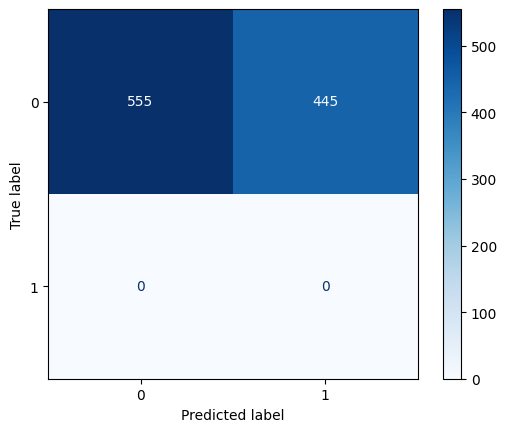

In [33]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt
import pandas as pd

# Charger résultats val
val_csv = "../results/face_matching/val_predictions.csv"
df = pd.read_csv(val_csv)

# Nettoyer la colonne prediction : "[0]" -> 0, "[1]" -> 1
df["prediction"] = df["prediction"].astype(str).str.strip("[]").astype(int)

# Label est déjà bon
y_true = df["label"].astype(int)
y_pred = df["prediction"].astype(int)

# Métriques
acc  = accuracy_score(y_true, y_pred)
prec = precision_score(y_true, y_pred)
rec  = recall_score(y_true, y_pred)
f1   = f1_score(y_true, y_pred)

print(f"Accuracy : {acc:.4f}")
print(f"Precision: {prec:.4f}")
print(f"Recall   : {rec:.4f}")
print(f"F1-score : {f1:.4f}")

# Matrice de confusion
cm = confusion_matrix(y_true, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot(cmap="Blues")
plt.show()

## 8. Inférence sur Test
- Générer `results/face_matching/face_matching_predictions.csv`
- Format strict demandé par l’organisation

In [34]:
import os, sys, json
import torch
import torch.nn.functional as F
from torch.utils.data import DataLoader
from PIL import Image
import torchvision.transforms as transforms

# === Chemins & prérequis ===
TEST_DIR = os.path.join("..", config["paths"]["test_dir"])               # ex: ../data/tache1/test
OUT_DIR  = os.path.join("..", config["paths"]["output_results"])         # ex: ../results/face_matching
WEIGHTS  = os.path.join("..", config["paths"]["output_models"], "best.pth")
os.makedirs(OUT_DIR, exist_ok=True)

# === Dataset test simple (image, filename) ===
class FaceTestDataset(torch.utils.data.Dataset):
    def __init__(self, root, transform=None):
        self.root = root
        self.transform = transform
        self.files = [f for f in os.listdir(root) if f.lower().endswith((".jpg", ".png", ".jpeg"))]
        self.files.sort()
    def __len__(self): return len(self.files)
    def __getitem__(self, idx):
        fname = self.files[idx]
        img   = Image.open(os.path.join(self.root, fname)).convert("RGB")
        if self.transform: img = self.transform(img)
        return img, fname

# === Transform identique à l'entraînement ===
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor()
])

# === Device & modèle ===
device = torch.device("mps" if torch.backends.mps.is_available() else "cpu")
model = FaceMatchingNet().to(device)
assert os.path.isfile(WEIGHTS), f"Poids introuvables: {WEIGHTS}"
model.load_state_dict(torch.load(WEIGHTS, map_location=device))
model.eval()

# === Embeddings pour toutes les images du test ===
test_ds  = FaceTestDataset(TEST_DIR, transform=transform)
test_dl  = DataLoader(test_ds, batch_size=64, shuffle=False)
filenames, embs = [], []

with torch.no_grad():
    for imgs, fnames in test_dl:
        imgs = imgs.to(device)
        # On utilise la branche d'embedding (forward_once)
        feats = model.forward_once(imgs) if hasattr(model, "forward_once") else model.embedding_net(imgs)
        feats = F.normalize(feats, p=2, dim=1)  # normalisation L2
        embs.append(feats.cpu())
        filenames.extend(list(fnames))

embs = torch.cat(embs, dim=0)  # [N, D]
N    = embs.size(0)

# === Matrice de similarité cosinus ===
# sim[i,j] ~ proximité; on met diag à -inf pour éviter l'auto-matching
sim = embs @ embs.T
sim.fill_diagonal_(-float("inf"))

# === Appariement greedy 1-1 (on forme ~N/2 paires uniques avec score décroissant) ===
pairs = []
matched = set()
# Récupère toutes les paires (i<j) triées par similarité décroissante, sans construire une liste géante
# On procède par itérations: pour chaque i non apparié, on prend son meilleur j non apparié
for _ in range(N // 2):
    # Trouver l'indice i non matché avec meilleure piste
    best_i, best_j, best_s = None, None, -1.0
    for i in range(N):
        if i in matched: 
            continue
        # meilleur j pour cet i
        s, j = torch.max(sim[i], dim=0)
        s = s.item(); j = j.item()
        if j in matched:
            # on tente de trouver le meilleur j non matché pour i
            # (fallback rapide): on met sim[i, j] à -inf et on retente 3 fois
            tries = 0
            while j in matched and tries < 3:
                sim[i, j] = -float("inf")
                s, j = torch.max(sim[i], dim=0)
                s = s.item(); j = j.item()
                tries += 1
        if j not in matched and s > best_s:
            best_s = s; best_i = i; best_j = j
    if best_i is None or best_j is None:
        break
    pairs.append((filenames[best_i], filenames[best_j], float(best_s)))
    # On invalide ces deux lignes/colonnes pour ne plus les réutiliser
    matched.add(best_i); matched.add(best_j)
    sim[best_i, :] = -float("inf"); sim[:, best_i] = -float("inf")
    sim[best_j, :] = -float("inf"); sim[:, best_j] = -float("inf")

# === Sauvegarde CSV (img1,img2,score) ===
out_csv = os.path.join(OUT_DIR, "face_matching_pairs.csv")
with open(out_csv, "w") as f:
    f.write("img1,img2,similarity\n")
    for a,b,s in pairs:
        f.write(f"{a},{b},{s:.6f}\n")

print(f"✅ Appariements produits: {len(pairs)} paires")
print(f"💾 Fichier écrit: {out_csv}")
# === Conversion en format attendu pour soumission ===
import pandas as pd

pairs_csv = os.path.join(OUT_DIR, "face_matching_pairs.csv")
df = pd.read_csv(pairs_csv)

# Appliquer un seuil sur la similarité pour produire un label binaire (0=different, 1=même personne)
df["label"] = (df["similarity"] > 0.5).astype(int)

# Garder uniquement les colonnes demandées
submit_csv = os.path.join(OUT_DIR, "face_matching_predictions.csv")
df[["img1","img2","label"]].to_csv(submit_csv, index=False)

print(f"✅ Fichier de soumission généré : {submit_csv}")



✅ Appariements produits: 1000 paires
💾 Fichier écrit: ../results/face_matching/face_matching_pairs.csv
✅ Fichier de soumission généré : ../results/face_matching/face_matching_predictions.csv
